# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

%load_ext autoreload
%autoreload 2

# Load irradiance data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')

In [3]:
cols = ['Global_Wm2', 'Date-Time']

In [4]:
data = pd.read_csv(file, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])

In [5]:
data.index = data.index.tz_localize('Etc/GMT+7')

In [6]:
data = data.reindex(
    pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')
).fillna(0)

In [7]:
data = pd.Series(data['Global_Wm2'], index=data.index)

In [8]:
print(type(data))

<class 'pandas.core.series.Series'>


In [9]:
data[data < 0] = 0

# Set up PVLib system

In [10]:
site_azimuth = 180
site_elevation = 1658
site_tilt = 35
site_lat = 35.0549
site_lon = -106.5433

In [11]:
rtc_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=site_tilt, surface_azimuth=site_azimuth)
rtc_loc = pvlib.location.Location(site_lat, site_lon, altitude=site_elevation)
rtc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=rtc_no_loc, location=rtc_loc)

# Test method

In [12]:
def metrics_plot(series, is_clear, result):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

    ax[0].set_title('Clear periods')
    _ = ax[0].plot(series.index, series)
    _ = ax[0].scatter(series.index[is_clear], series[is_clear], facecolor='none', edgecolor='green')
    
    ax[1].set_title('Metric')
    _ = ax[1].plot(series.index, series)
    p = ax[1].scatter(series.index, series, c=result['metric'], cmap=matplotlib.cm.jet)
    fig.colorbar(p, ax=ax[1], label='cloudiness')

    fig.tight_layout()

In [13]:
def pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 5))

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[is_clear & ~pvlib_is_clear], sample[is_clear & ~pvlib_is_clear], 
               facecolor='none', edgecolor='green', label='model free')
    _ = ax.scatter(sample.index[pvlib_is_clear & ~is_clear], sample[pvlib_is_clear & ~is_clear], 
               facecolor='none', edgecolor='red', label='pvlib')
    _ = ax.scatter(sample.index[pvlib_is_clear & is_clear], sample[is_clear & pvlib_is_clear], 
               facecolor='none', edgecolor='yellow', label='both')
    _ = ax.legend()
    
    ax = axes[1]
    _ = ax.plot(is_clear.index, np.cumsum(is_clear.astype(int)), label='model free')
    _ = ax.plot(pvlib_is_clear.index, np.cumsum(pvlib_is_clear.astype(int)), label='pvlib')
    _ = ax.legend()
    
    fig.tight_layout()

## Clear sky verification

In [14]:
sample = data[(data.index >= '2016-07-01') & (data.index < '2016-07-08')]

In [15]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = clear_skies['ghi']

### Standard method

In [16]:
is_clear, cs_result = clearsky_detect_model_free.model_free_detect(clear_skies, window=30, 
                                                                   metric_tol=.05, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:54: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


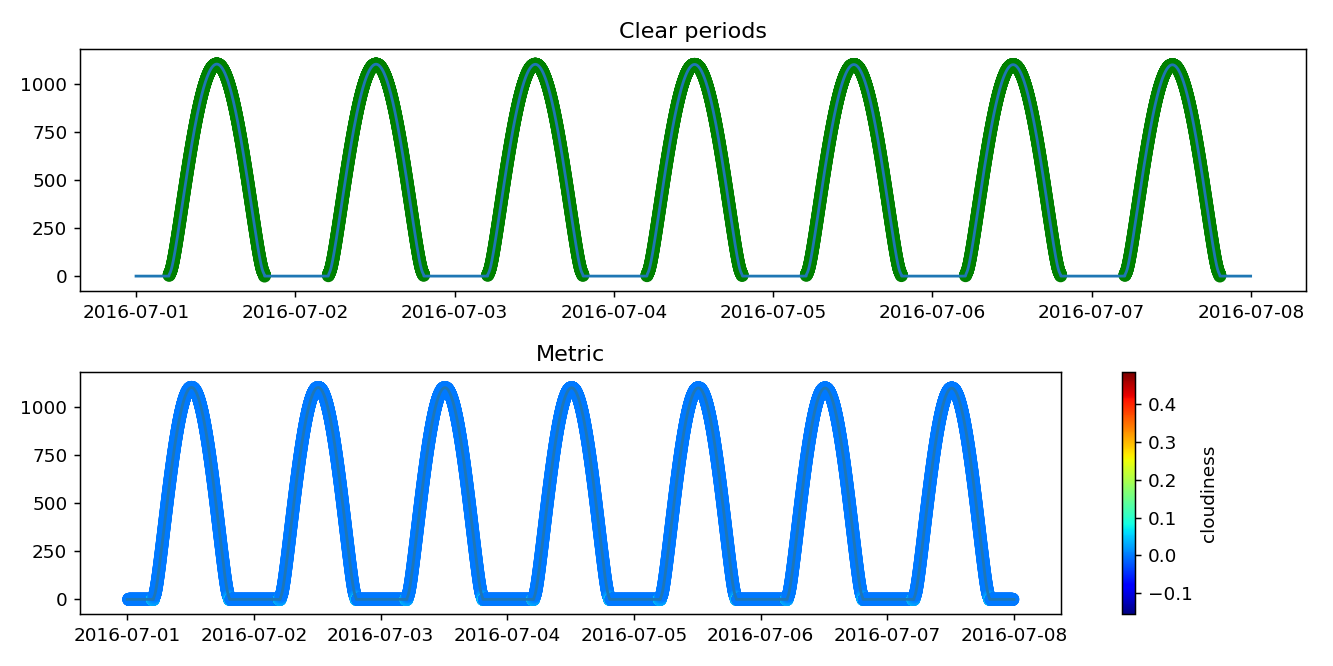

In [17]:
metrics_plot(clear_skies, is_clear, cs_result)

### Democratic method

In [18]:
is_clear, result = clearsky_detect_model_free.model_free_detect_democratic(clear_skies, window=30, 
                                                                           metric_tol=.05, pct_tol=.75, 
                                                                           verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:100: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


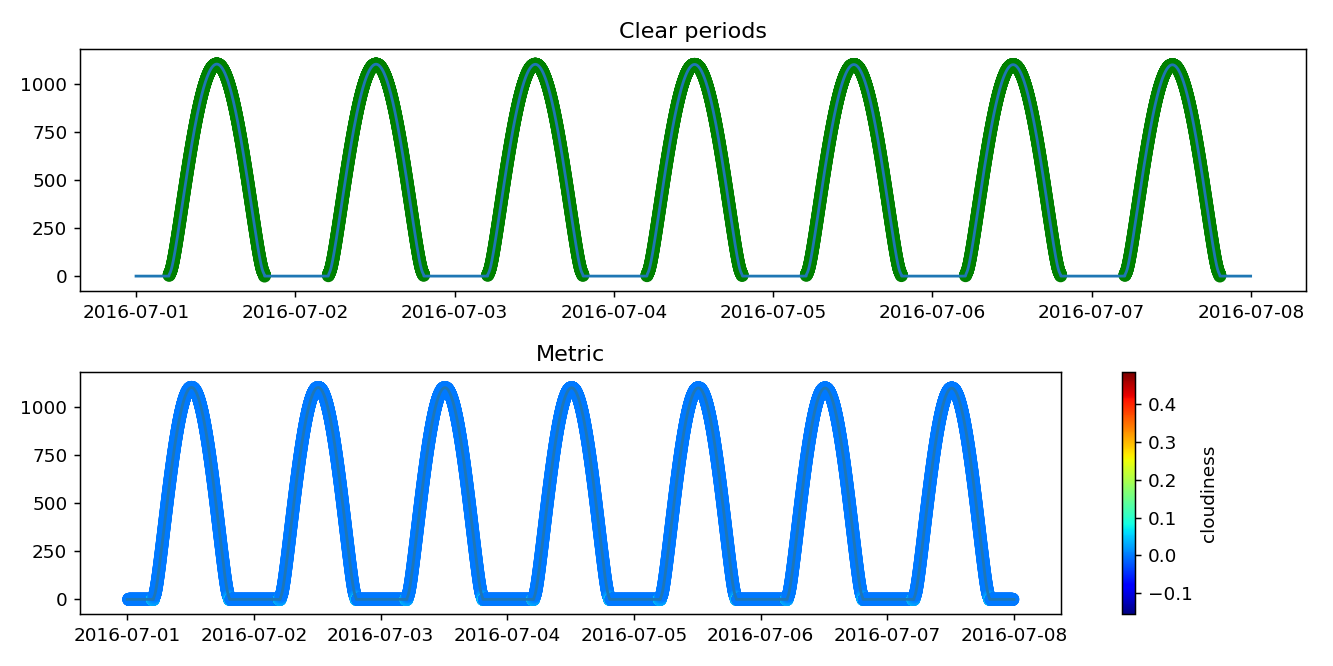

In [19]:
metrics_plot(clear_skies, is_clear, cs_result)

### Mean method

In [20]:
is_clear, result = clearsky_detect_model_free.model_free_detect_meanval(clear_skies, window=30, 
                                                                        metric_tol=.05, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:154: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


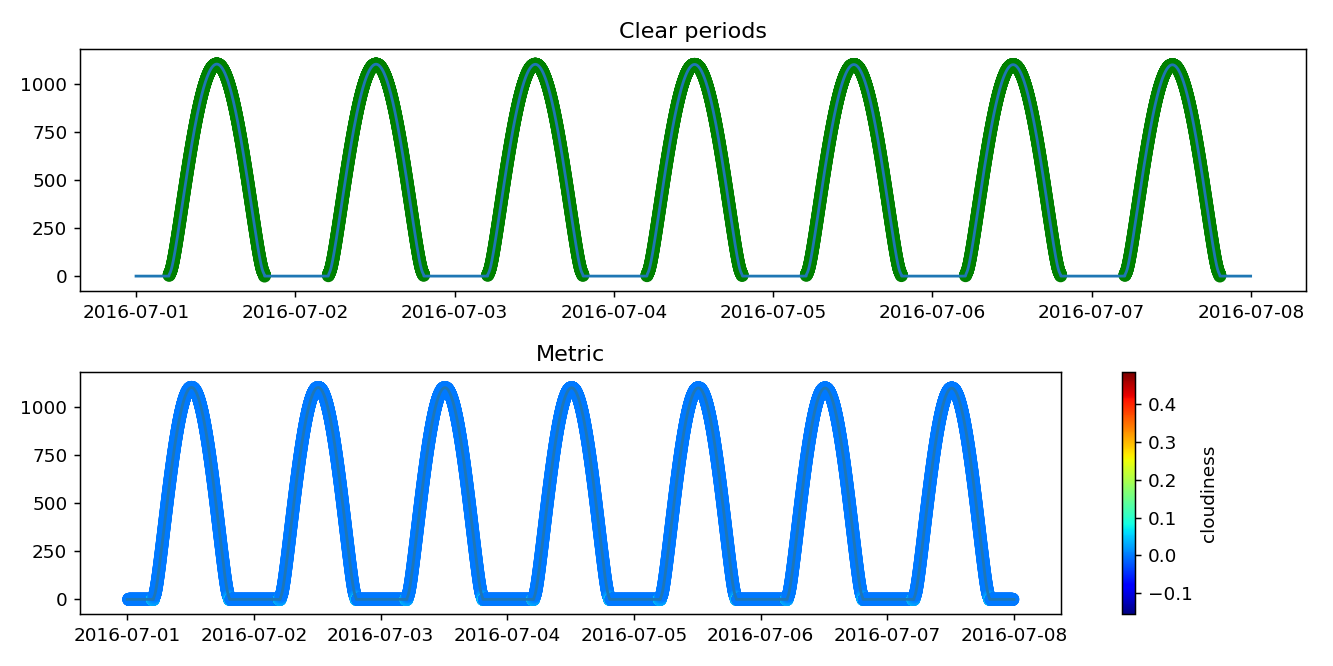

In [21]:
metrics_plot(clear_skies, is_clear, cs_result)

## Samples from SNL

In [22]:
# def agreement(model_free, pvlib):
#     fig, ax = plt.subplots(figsize=(10, 2.5))
#     _ = ax.plot(model_free.index, np.cumsum(model_free.astype(int)), label='model free')
#     _ = ax.plot(pvlib.index, np.cumsum(pvlib.astype(int)), label='pvlib')
#     _ = ax.legend()

Get pvlib clear sky times for comparison

In [23]:
pvlib_is_clear = pvlib.clearsky.detect_clearsky(sample, clear_skies, sample.index, 10)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


### Standard method

In [24]:
is_clear, result = clearsky_detect_model_free.model_free_detect(sample, window=30, metric_tol=.05, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:54: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


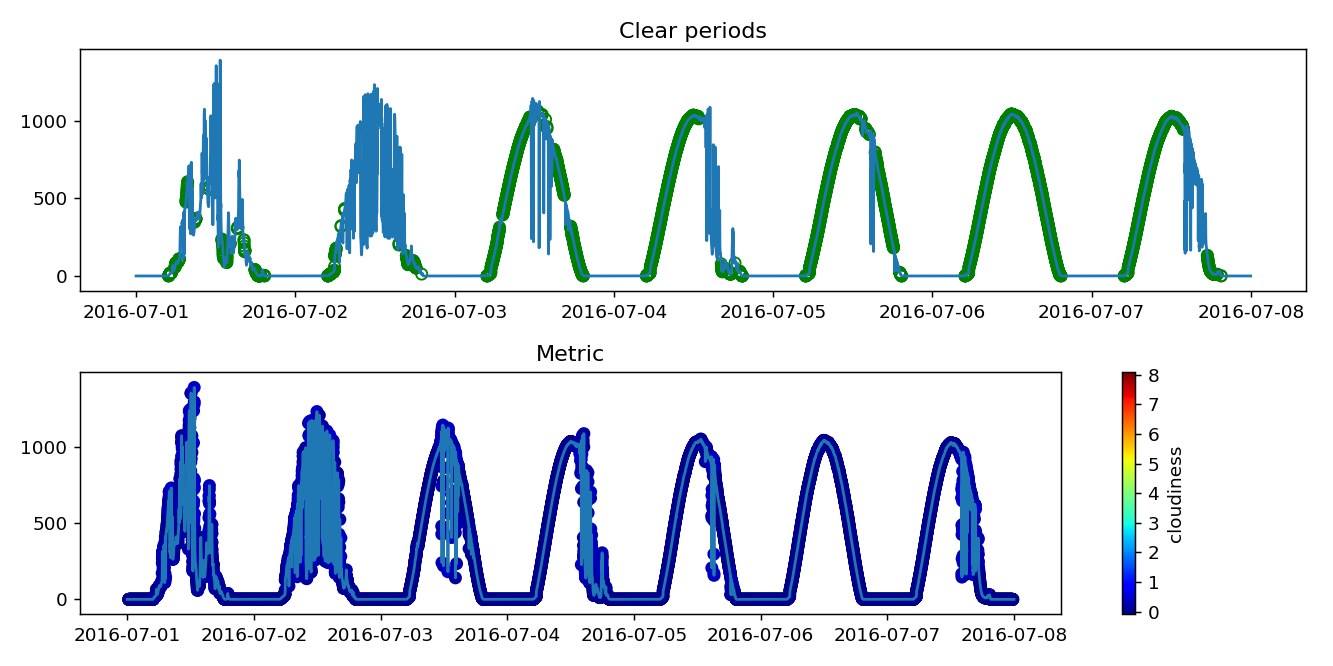

In [25]:
metrics_plot(sample, is_clear, result)

<IPython.core.display.Javascript object>


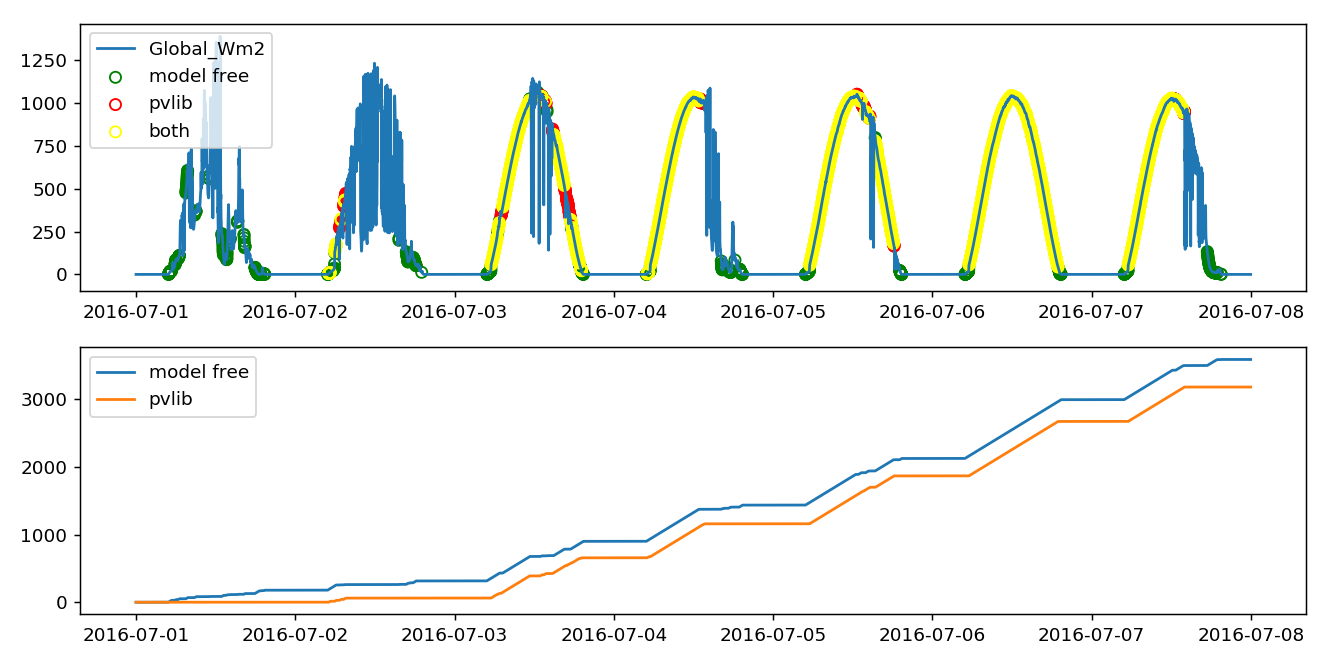

In [26]:
pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear)

In [27]:
# agreement(is_clear, pvlib_is_clear)

### Democratic method

In [28]:
is_clear, result = clearsky_detect_model_free.model_free_detect_democratic(sample, window=30, 
                                                                           metric_tol=.05, pct_tol=.75, 
                                                                           verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:100: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


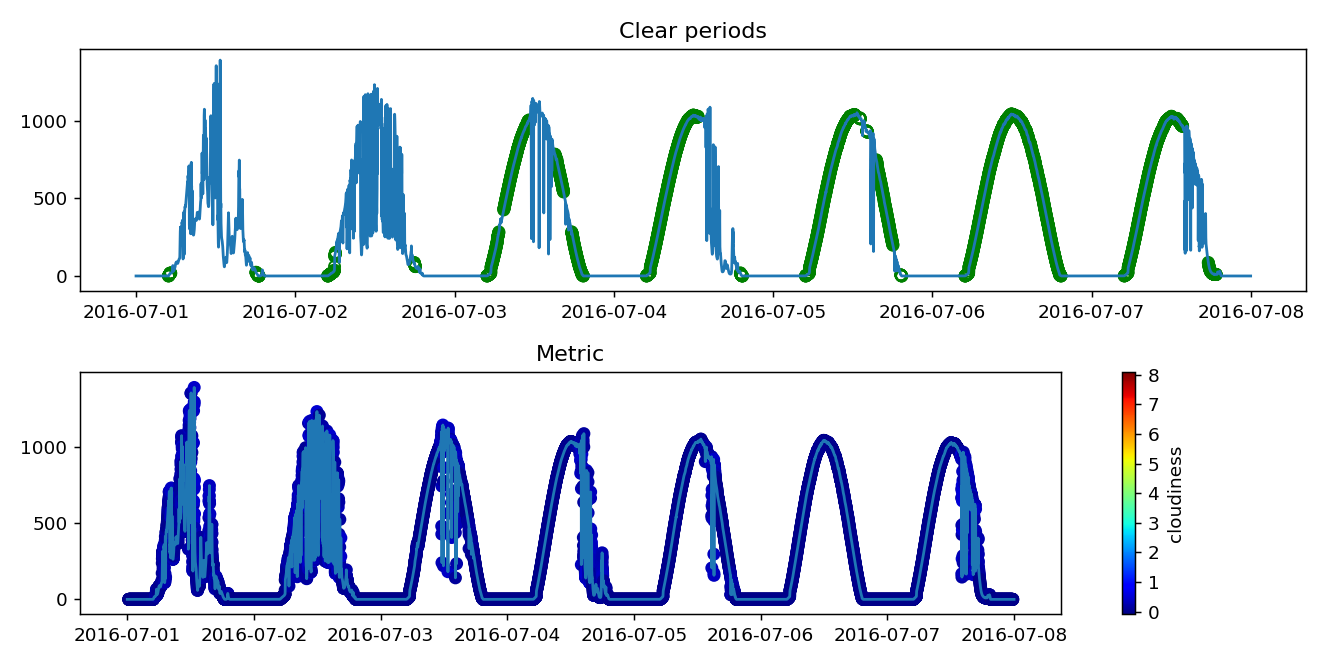

In [29]:
metrics_plot(sample, is_clear, result)

<IPython.core.display.Javascript object>


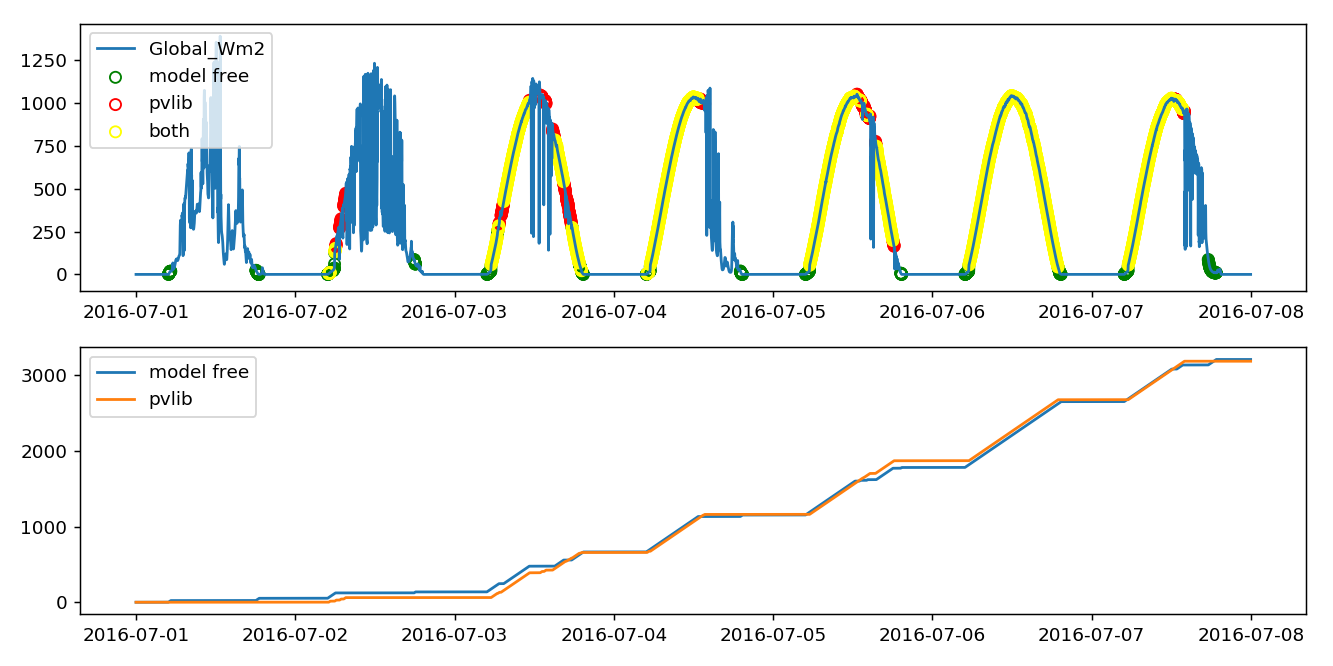

In [30]:
pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear)

In [31]:
# agreement(is_clear, pvlib_is_clear)

### Mean method

In [32]:
is_clear, result = clearsky_detect_model_free.model_free_detect_meanval(sample, window=30, 
                                                                        metric_tol=.05, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:154: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


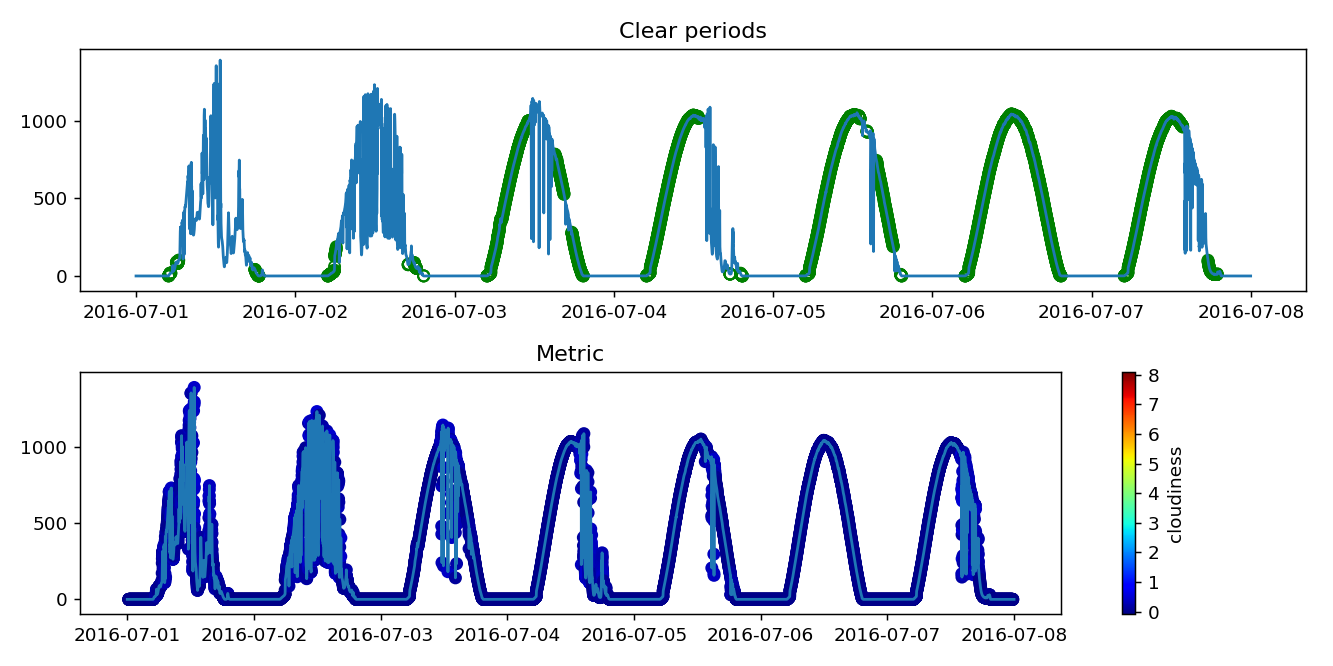

In [33]:
metrics_plot(sample, is_clear, result)

<IPython.core.display.Javascript object>


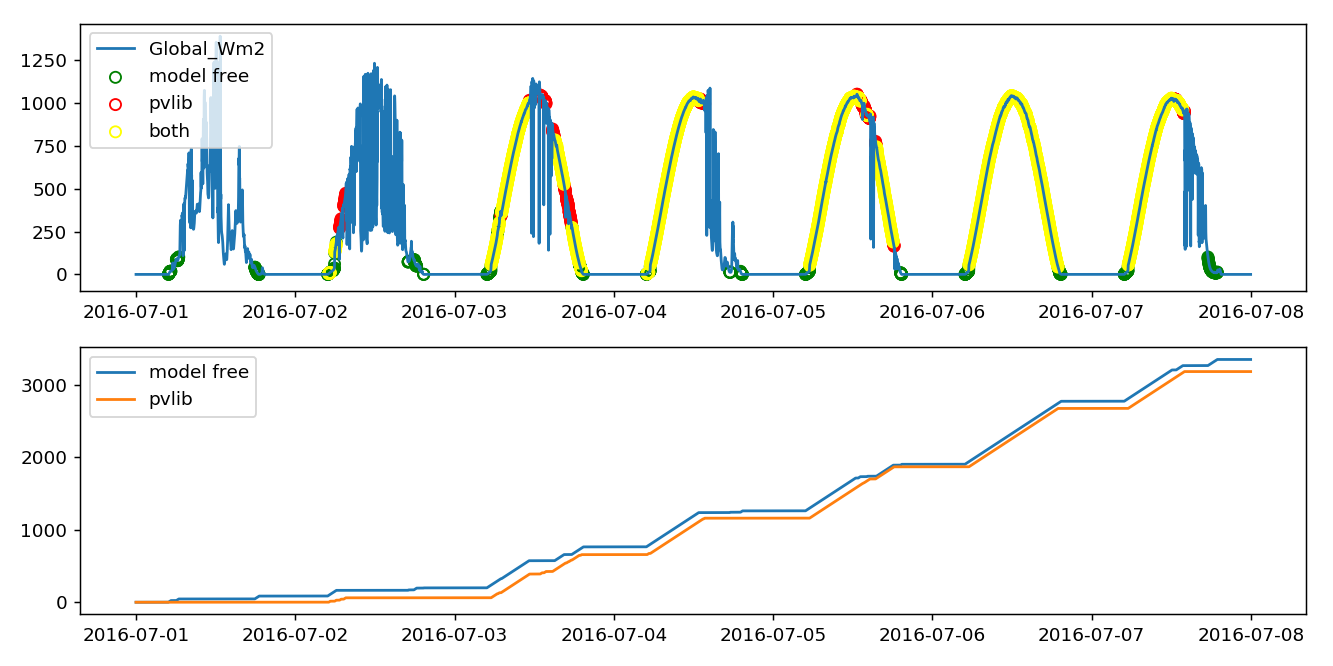

In [34]:
pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear)

In [35]:
# agreement(is_clear, pvlib_is_clear)